# Site Discovery Recommender - Walk-Forward Evaluation

This notebook demonstrates a site discovery/exploration recommender system:

**Problem**: Predict which sites a pilot will discover next based on their exploration history

**Approach**:
- **Training data**: Binary pilot-site interactions (visited or not)
- **Train/val/test split**: By pilots (each pilot in one split only)
- **Evaluation**: Walk-forward sequences simulating progressive discovery
  - For pilot visiting [S1, S2, S3, S4]: evaluate [S1]→S2, [S1,S2]→S3, [S1,S2,S3]→S4

**Model**: SVD-based collaborative filtering


In [1]:
import os
import logging

import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pickle
from scipy.stats import loguniform

from process import (
    load_flight_data, get_first_visits, filter_pilots_and_sites,
    split_pilots, create_walk_forward_sequences, create_interaction_matrix,
    build_train_site_vocabulary
)
from hyper_opt import (
    perform_hyperparameter_search, plot_hyperparameter_analysis,
    plot_metric_correlations, get_best_params, get_uniform
)
from metrics import evaluate_walk_forward, print_metrics_summary, aggregate_metrics
from svd import SVDRecommender
import utils
import plots

In [2]:
%load_ext autoreload
%autoreload 2

## 1. Setup and Load Data


In [3]:
# Database connection
load_dotenv()

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler()
    ]
)

connection_string = "postgresql://{user}:{password}@{host}:{port}/{db}".format(
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    host=os.getenv('DB_HOST'),
    port=os.getenv('DB_PORT'),
    db=os.getenv('DB_NAME')
)
engine = create_engine(connection_string)

In [4]:
# Load flight data
df = load_flight_data(engine)

2025-10-17 23:33:09,977 - process - INFO - Loading flight data...
2025-10-17 23:33:32,634 - process - INFO - Loaded 1,211,925 flights
2025-10-17 23:33:33,209 - process - INFO - Unique pilots: 31,311
2025-10-17 23:33:33,228 - process - INFO - Unique sites: 252
2025-10-17 23:33:33,364 - process - INFO - Date range: 2015-01-01 to 2024-12-31


## 2. Extract First Visits and Filter


In [5]:
# Get first visit to each site for each pilot
first_visits = get_first_visits(df)


2025-10-17 23:33:39,681 - process - INFO - First visits: 179,907
2025-10-17 23:33:39,735 - process - INFO - Pilots with visits: 31,311
2025-10-17 23:33:39,740 - process - INFO - Unique sites visited: 252


In [6]:
# Filter to active pilots and sites
# Pilot must have visited at least 3 sites (to create meaningful sequences)
# Site must be visited by at least 5 pilots (to have enough training signal)
filtered_visits = filter_pilots_and_sites(
    first_visits, 
    min_sites_per_pilot=3,
    min_pilots_per_site=5
)

2025-10-17 23:33:44,101 - process - INFO - After filtering:
2025-10-17 23:33:44,148 - process - INFO -   Pilots: 18,921 (visited 3+ sites)
2025-10-17 23:33:44,151 - process - INFO -   Sites: 252 (visited by 5+ pilots)
2025-10-17 23:33:44,154 - process - INFO -   First visits: 162,795
2025-10-17 23:33:44,220 - process - INFO -   Sites per pilot - mean: 8.6, median: 6, max: 62


## 3. Split by Pilots


In [7]:
# Split pilots into train/val/test (70/15/15)
# Each pilot appears in exactly one split
train_df, val_df, test_df = split_pilots(
    filtered_visits,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    random_seed=42
)

2025-10-17 23:33:47,980 - process - INFO - 
Pilot-based split:
2025-10-17 23:33:47,981 - process - INFO -   Train: 13,244 pilots, 114,035 visits
2025-10-17 23:33:47,982 - process - INFO -   Val:   2,838 pilots, 24,700 visits
2025-10-17 23:33:47,982 - process - INFO -   Test:  2,839 pilots, 24,060 visits


## 4. Create Walk-Forward Sequences


In [8]:
# Create walk-forward evaluation sequences
# For pilot with [S1, S2, S3, S4]: create [S1]→S2, [S1,S2]→S3, [S1,S2,S3]→S4
val_sequences = create_walk_forward_sequences(val_df, min_history=1)
test_sequences = create_walk_forward_sequences(test_df, min_history=1)

2025-10-17 23:33:52,292 - process - INFO - 
Created 21,862 walk-forward sequences
2025-10-17 23:33:52,297 - process - INFO -   From 2,838 pilots
2025-10-17 23:33:52,306 - process - INFO -   Avg sequences per pilot: 7.7
2025-10-17 23:33:53,279 - process - INFO - 
Created 21,221 walk-forward sequences
2025-10-17 23:33:53,285 - process - INFO -   From 2,839 pilots
2025-10-17 23:33:53,295 - process - INFO -   Avg sequences per pilot: 7.5


In [9]:
# Example sequences
print("\nExample validation sequences:")
for i, seq in enumerate(val_sequences[:3]):
    print(f"     History IDs: {seq['history_sites']}")
    print(f"     History Names: {seq['history_names']}")
    print(f"     Target ID: {seq['target_site']}, Name: {seq['target_name']}")


Example validation sequences:
     History IDs: [245]
     History Names: ['Vértesszőlős']
     Target ID: 243, Name: Csolnok
     History IDs: [245, 243]
     History Names: ['Vértesszőlős', 'Csolnok']
     Target ID: 242, Name: Óbuda
     History IDs: [245, 243, 242]
     History Names: ['Vértesszőlős', 'Csolnok', 'Óbuda']
     Target ID: 185, Name: Col de La Forclaz


## 5. Train SVD Model - Including Hyperameter optimization


In [10]:
# Define hyperparameter search space
SEARCH_SPACE = {
    'n_factors': [32, 64, 96],  # Discrete values
    'sigma_power': get_uniform(0.8, 1.5),  # Continuous uniform distribution
}

# Fixed parameters (not searched)
FIXED_PARAMS = {
    'apply_idf': True
}

# Number of random combinations to try
N_ITER = 100

# Metric to optimize
METRIC = 'hit_rate'
K = 5 # K to optimize

Ks = [3, 5, 10] # Ks to report

In [11]:
# Create binary interaction matrix from training data
interaction_matrix, pilot_to_idx, site_to_idx, idx_to_site, site_id_to_name = create_interaction_matrix(train_df)

# Build training site vocabulary (for filtering eval sequences)
train_site_vocab = build_train_site_vocabulary(train_df)

2025-10-17 23:34:05,461 - process - INFO - 
Interaction matrix:
2025-10-17 23:34:05,462 - process - INFO -   Shape: 13244 pilots × 252 sites
2025-10-17 23:34:05,513 - process - INFO -   Density: 0.034168
2025-10-17 23:34:05,514 - process - INFO -   Total interactions: 114,035


In [12]:
# Prepare training data tuple
train_data = (interaction_matrix, pilot_to_idx, site_to_idx, idx_to_site, site_id_to_name, train_df)

# Run hyperparameter search
results_df = perform_hyperparameter_search(
    model_class=SVDRecommender,
    train_data=train_data,
    val_sequences=val_sequences,
    train_site_vocab=train_site_vocab,
    search_space=SEARCH_SPACE,
    fixed_params=FIXED_PARAMS,
    n_iter=N_ITER,
    metric=METRIC,
    k=K
)

# Display top results
print(f"\nTop 10 configurations by {METRIC}@{K}:")
results_df.head(10)

2025-10-17 23:34:10,297 - hyper_opt - INFO - Starting hyperparameter search with 100 iterations
2025-10-17 23:34:10,298 - hyper_opt - INFO - Optimizing for: hit_rate@5
Hyperparameter search:   0%|                                                                    | 0/100 [00:00<?, ?it/s]2025-10-17 23:34:10,310 - svd - INFO - Computing IDF weights for sites...
2025-10-17 23:34:10,313 - svd - INFO - IDF weights - min: 1.040, max: 5.828, mean: 3.771
2025-10-17 23:34:10,321 - svd - INFO - IDF weighting applied to interaction matrix
2025-10-17 23:34:10,323 - svd - INFO - Computing SVD with 96 factors...
2025-10-17 23:34:11,510 - svd - INFO - U shape: (13244, 96)
2025-10-17 23:34:11,513 - svd - INFO - Sigma shape: (96,)
2025-10-17 23:34:11,524 - svd - INFO - Vt shape: (96, 252)
2025-10-17 23:34:11,527 - svd - INFO - Explained variance (top 10 singular values): [282.41592358 233.93597233 187.05485244 164.96308525 156.31854542
 149.02460188 140.86062268 135.6135685  134.04822461 116.18703608]



Top 10 configurations by hit_rate@5:


,n_factors,sigma_power,hit_rate,mrr,ndcg,coverage,avg_log_pop,hit_rate@5
0,96,1.357580,0.387796,0.218541,0.260355,0.984127,6.453886,0.387796
44,96,1.339889,0.387796,0.218331,0.260198,0.984127,6.448325,0.387796
55,96,1.339677,0.387796,0.218308,0.260180,0.984127,6.448267,0.387796
1,96,1.312396,0.387567,0.218037,0.259907,0.984127,6.439096,0.387567
42,96,1.370823,0.387339,0.218692,0.260365,0.984127,6.458735,0.387339
47,96,1.395027,0.387339,0.219189,0.260742,0.988095,6.466375,0.387339
53,96,1.299271,0.387339,0.217937,0.259774,0.984127,6.433772,0.387339
66,96,1.286349,0.387293,0.217804,0.259659,0.984127,6.428942,0.387293
22,96,1.278284,0.387293,0.217799,0.259661,0.984127,6.426744,0.387293
92,96,1.270495,0.387293,0.217615,0.259530,0.984127,6.423952,0.387293


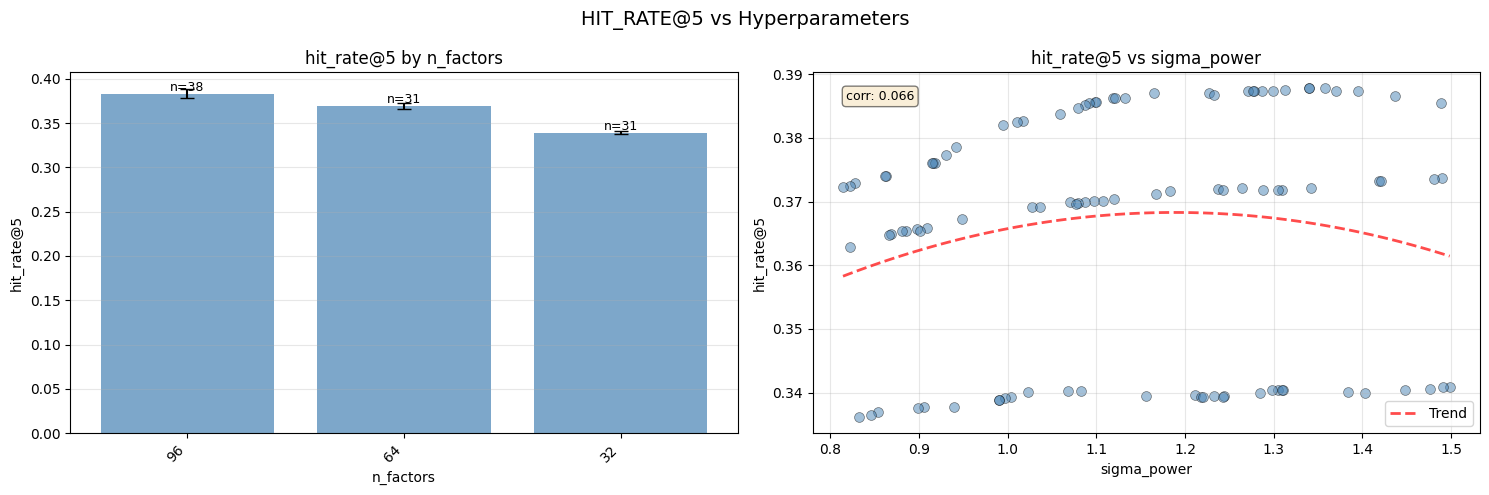

In [13]:
# Plot hyperparameter analysis
param_names = list(SEARCH_SPACE.keys())
fig = plot_hyperparameter_analysis(
    results_df,
    param_names,
    metric=METRIC,
    k=K,
    figsize=(15, 5)
)
plt.show()

In [14]:
# Re-train with best params
best_config = results_df.iloc[0]
best_params = {key: best_config[key] for key in SEARCH_SPACE.keys()}

model = SVDRecommender(**best_params)
model.fit(interaction_matrix, pilot_to_idx, site_to_idx, idx_to_site, site_id_to_name)

2025-10-18 02:43:05,027 - svd - INFO - No IDF weighting applied (using raw interaction matrix)
2025-10-18 02:43:05,028 - svd - INFO - Computing SVD with 96.0 factors...
2025-10-18 02:43:08,316 - svd - INFO - U shape: (13244, 96)
2025-10-18 02:43:08,330 - svd - INFO - Sigma shape: (96,)
2025-10-18 02:43:08,331 - svd - INFO - Vt shape: (96, 252)
2025-10-18 02:43:08,335 - svd - INFO - Explained variance (top 10 singular values): [119.08372487  89.73634883  71.4574136   55.71071468  51.47060619
  48.95251903  44.92207675  43.72662987  42.47128799  40.102729  ]
2025-10-18 02:43:08,352 - svd - INFO - Applied sigma_power=1.3575800908021631 to singular values
2025-10-18 02:43:08,369 - svd - INFO - Transformed singular values (top 10): [657.86367104 448.03403975 328.86502786 234.55876122 210.65841245
 196.79087598 175.12435951 168.82785872 162.28184773 150.11946433]
2025-10-18 02:43:08,411 - svd - INFO - Site embeddings shape: (252, 96)
2025-10-18 02:43:08,418 - svd - INFO - Computing site simi

## 6. Evaluate on Validation Set


In [15]:
utils.print_sample_sequence(val_sequences[100], model, top_k=10)

Pilot's history: ['Bassano', 'Mieroszów']
Actual next site: Černá hora (ID: 4)

Top 10 recommendations:
  1. Andrzejowka: 0.6475
  2. Černá hora: 0.6221 ← TARGET
  3. Srbce: 0.5857
  4. Dolní Morava: 0.5658
  5. Zvičina: 0.5549
  6. Kozákov: 0.5170
  7. Kobala: 0.4679
  8. Lijak: 0.4533
  9. Col Rodella: 0.4419
  10. Zásada: 0.4394


In [16]:
# Evaluate using walk-forward sequences
# Pass train_df to compute coverage and avg_log_pop metrics
val_metrics = evaluate_walk_forward(
    model,
    val_sequences,
    train_site_vocab,
    train_df=train_df,
    k_values=Ks,
    verbose=True
)

2025-10-18 02:43:16,204 - metrics - INFO - Computed popularity for 252 sites
2025-10-18 02:43:16,247 - metrics - INFO - Evaluating 21,862 valid sequences (out of 21,862)
100%|████████████████████████████████████████████████████████████████████████████| 21862/21862 [01:55<00:00, 188.79it/s]
2025-10-18 02:45:12,054 - metrics - INFO - 
2025-10-18 02:45:12,055 - metrics - INFO - Walk-Forward Evaluation Results
2025-10-18 02:45:12,055 - metrics - INFO - ============================================================
2025-10-18 02:45:12,057 - metrics - INFO - 
Metrics @ K=3:
2025-10-18 02:45:12,060 - metrics - INFO -   Hit Rate@3:  0.2224
2025-10-18 02:45:12,069 - metrics - INFO -   MRR:           0.1935
2025-10-18 02:45:12,072 - metrics - INFO -   NDCG@3:      0.1684
2025-10-18 02:45:12,074 - metrics - INFO -   Coverage@3:  0.9841 (248/252 sites)
2025-10-18 02:45:12,078 - metrics - INFO -   Avg Log-Pop@3: 5.9079
2025-10-18 02:45:12,080 - metrics - INFO - 
Metrics @ K=5:
2025-10-18 02:45:12,089

## 7. Evaluate on Test Set


In [17]:
# Evaluate on test set
# Pass train_df to compute coverage and avg_log_pop metrics
test_metrics = evaluate_walk_forward(
    model,
    test_sequences,
    train_site_vocab,
    train_df=train_df,
    k_values=Ks,
    verbose=True
)

2025-10-18 02:45:15,642 - metrics - INFO - Computed popularity for 252 sites
2025-10-18 02:45:15,795 - metrics - INFO - Evaluating 21,221 valid sequences (out of 21,221)
100%|████████████████████████████████████████████████████████████████████████████| 21221/21221 [01:55<00:00, 183.70it/s]
2025-10-18 02:47:11,325 - metrics - INFO - 
2025-10-18 02:47:11,332 - metrics - INFO - Walk-Forward Evaluation Results
2025-10-18 02:47:11,334 - metrics - INFO - ============================================================
2025-10-18 02:47:11,338 - metrics - INFO - 
Metrics @ K=3:
2025-10-18 02:47:11,343 - metrics - INFO -   Hit Rate@3:  0.2259
2025-10-18 02:47:11,349 - metrics - INFO -   MRR:           0.1970
2025-10-18 02:47:11,356 - metrics - INFO -   NDCG@3:      0.1705
2025-10-18 02:47:11,358 - metrics - INFO -   Coverage@3:  0.9802 (247/252 sites)
2025-10-18 02:47:11,363 - metrics - INFO -   Avg Log-Pop@3: 5.8881
2025-10-18 02:47:11,365 - metrics - INFO - 
Metrics @ K=5:
2025-10-18 02:47:11,367

## 8. Visualize Results


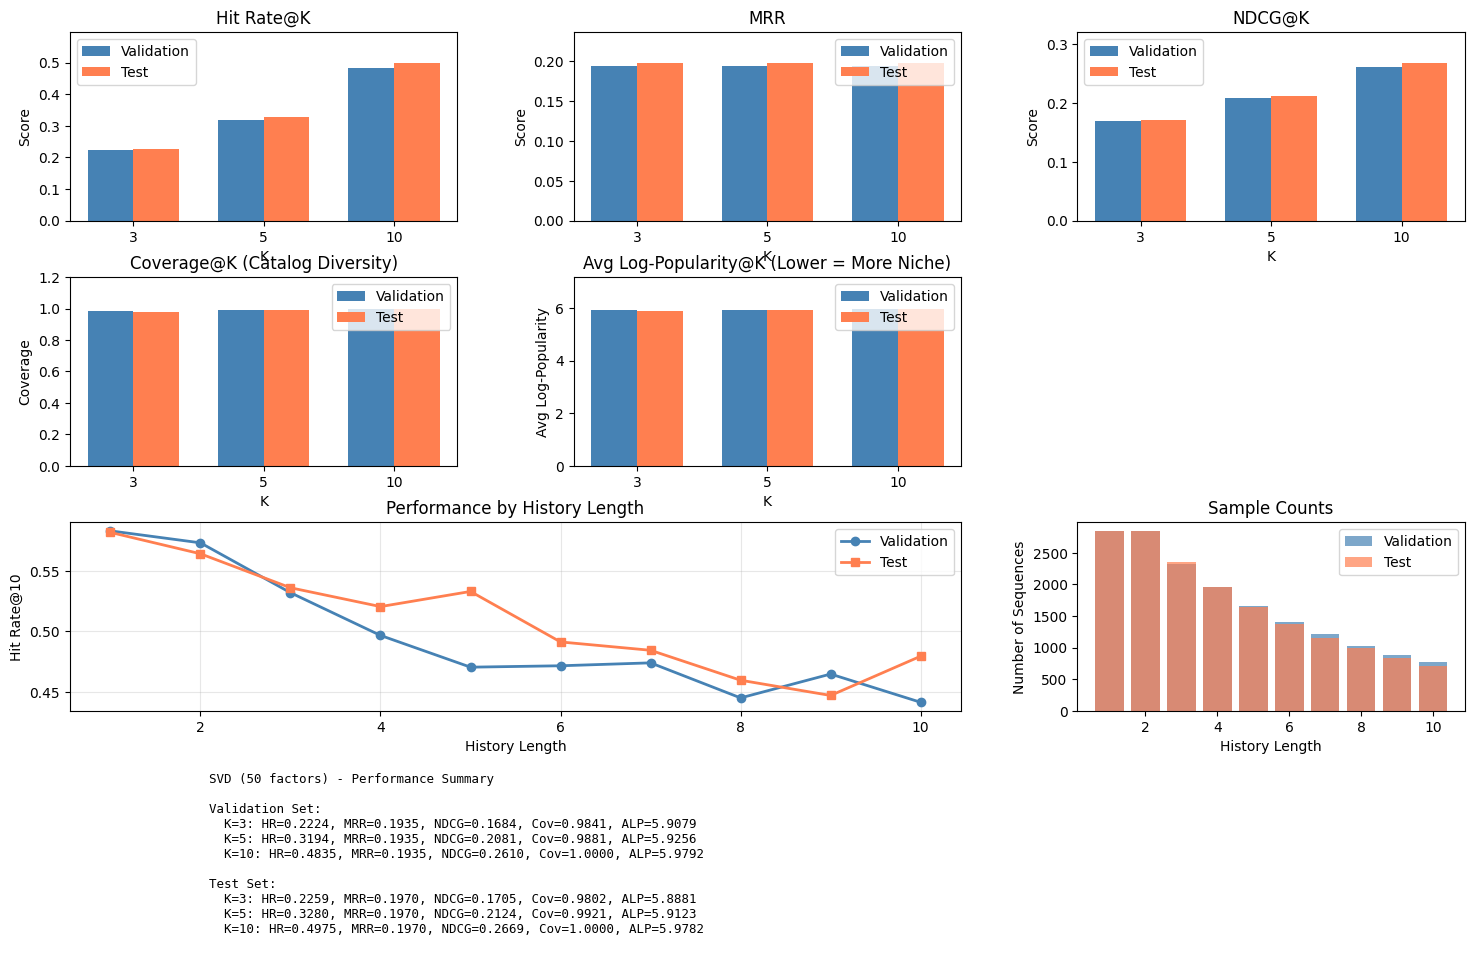

In [18]:
# Create a comprehensive dashboard with all visualizations
fig = plots.create_results_dashboard(
    val_metrics,
    test_metrics,
    model_name='SVD (50 factors)',
    k_values=Ks,
)
plt.show()

## 9. Save Model and Results


In [19]:
# Save the trained model
model.save('svd_model_walk_forward.pkl')

# Aggregate and save metrics
results = {
    'model_type': 'SVD',
    'n_factors': model.n_factors,
    'val_metrics': aggregate_metrics(val_metrics),
    'test_metrics': aggregate_metrics(test_metrics),
    'n_sites': len(site_to_idx),
    'n_train_pilots': len(train_df['pilot'].unique()),
    'n_val_pilots': len(val_df['pilot'].unique()),
    'n_test_pilots': len(test_df['pilot'].unique()),
    'n_train_visits': len(train_df),
    'n_val_sequences': len(val_sequences),
    'n_test_sequences': len(test_sequences),
}

with open('svd_results_walk_forward.pkl', 'wb') as f:
    pickle.dump(results, f)

print("\nModel and results saved!")
print("\nSummary:")
print(f"  Model: SVD with {model.n_factors} factors")
print(f"  Sites: {len(site_to_idx)}")
print(f"  Train pilots: {results['n_train_pilots']}")
print(f"  Val pilots: {results['n_val_pilots']}")
print(f"  Test pilots: {results['n_test_pilots']}")
print(f"\nValidation Performance:")
print(f"  Hit Rate@10: {results['val_metrics']['overall'][10]['hit_rate']:.4f}")
print(f"  MRR: {results['val_metrics']['overall'][10]['mrr']:.4f}")
print(f"  NDCG@10: {results['val_metrics']['overall'][10]['ndcg']:.4f}")
print(f"\nTest Performance:")
print(f"  Hit Rate@10: {results['test_metrics']['overall'][10]['hit_rate']:.4f}")
print(f"  MRR: {results['test_metrics']['overall'][10]['mrr']:.4f}")
print(f"  NDCG@10: {results['test_metrics']['overall'][10]['ndcg']:.4f}")

2025-10-18 02:47:23,298 - svd - INFO - Model saved to 'svd_model_walk_forward.pkl'



Model and results saved!

Summary:
  Model: SVD with 96.0 factors
  Sites: 252
  Train pilots: 13244
  Val pilots: 2838
  Test pilots: 2839

Validation Performance:
  Hit Rate@10: 0.4835
  MRR: 0.1935
  NDCG@10: 0.2610

Test Performance:
  Hit Rate@10: 0.4975
  MRR: 0.1970
  NDCG@10: 0.2669
